In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import albumentations as A
import torchvision.transforms as T

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 7.8 MB/s eta 0:00:00


In [3]:


from datasets import load_dataset

dataset = load_dataset("EduardoPacheco/FoodSeg103")



README.md:   0%|          | 0.00/6.71k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})


In [5]:
from datasets import DatasetDict

In [6]:
from datasets import DatasetDict

# Define the split ratio (e.g., 80% train, 20% dev)
split_ratio = 0.8

# Split the `train` dataset into new train and dev sets
train_val_split = dataset['train'].train_test_split(test_size=1 - split_ratio)

# Access the newly created splits
new_train_dataset = train_val_split['train']  # 80% of the original train set
new_dev_dataset = train_val_split['test']     # 20% of the original train set

# Now, we have:
# new_train_dataset -> the new train split
# new_dev_dataset -> the new dev split

# If needed, we can create a new DatasetDict that includes the updated train and dev sets
dataset = DatasetDict({
    'train': new_train_dataset,
    'dev': new_dev_dataset,
    'test': dataset['validation']  # Keeping the original validation set
})

# You can now use `updated_dataset_dict` for further processing or save it to disk.


In [7]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 3986
    })
    dev: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 997
    })
    test: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})


In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from PIL import Image
import os

# Define data augmentation transformations
train_transforms = T.Compose([
    T.ToTensor(),  # Converts PIL images to PyTorch tensors (C, H, W)\n",
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    box1, box2: [x_min, y_min, x_max, y_max]
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = inter_area / (box1_area + box2_area - inter_area)

    return iou

In [10]:
def calculate_precision_recall(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold=0.5, score_threshold=0.5):
    """
    Calculate precision and recall for a single image.
    pred_boxes: Predicted bounding boxes [x_min, y_min, x_max, y_max]
    pred_labels: Predicted labels
    pred_scores: Confidence scores for predictions
    gt_boxes: Ground truth bounding boxes
    gt_labels: Ground truth labels
    iou_threshold: IoU threshold for a prediction to be considered correct
    score_threshold: Confidence score threshold for predictions
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    matched_gt = set()

    # Filter out predictions with low confidence scores
    pred_boxes = [pred_boxes[i] for i in range(len(pred_scores)) if pred_scores[i] >= score_threshold]
    pred_labels = [pred_labels[i] for i in range(len(pred_scores)) if pred_scores[i] >= score_threshold]
    pred_scores = [score for score in pred_scores if score >= score_threshold]

    for i, pred_box in enumerate(pred_boxes):
        pred_label = pred_labels[i]
        
        max_iou = 0
        max_gt_idx = -1

        # Compare each predicted box with ground truth boxes
        for j, gt_box in enumerate(gt_boxes):
            if gt_labels[j] == pred_label and j not in matched_gt:
                iou = calculate_iou(pred_box, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    max_gt_idx = j

        if max_iou >= iou_threshold:
            true_positives += 1
            matched_gt.add(max_gt_idx)
        else:
            false_positives += 1

    false_negatives = len(gt_boxes) - len(matched_gt)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall


In [11]:
def calculate_map50(all_precisions):
    """
    Calculate mAP@50 by averaging precision across all images.
    all_precisions: List of precision values for each image
    """
    return np.mean(all_precisions)


In [12]:
class FoodDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __getitem__(self, idx):
        record = self.dataset[idx]
        
        # Load the image (convert to RGB if needed)
        image = record['image']
        if isinstance(image, str):  # If it's a path to the image, load it
            image = Image.open(image).convert("RGB")
        
        # Load the mask (segmentation mask), convert to a NumPy array
        mask_image = record['label']
        if isinstance(mask_image, str):  # If it's a path, load the mask
            mask_image = Image.open(mask_image).convert('L')  # Grayscale (assuming it's a single-channel mask)
        mask_array = np.array(mask_image)

        # Prepare lists for bounding boxes, labels, and masks
        boxes = []
        labels = []
        masks = []
        
        # Iterate through the class IDs in `classes_on_image`
        for class_id in record['classes_on_image']:
            labels.append(int(class_id))

            # Create a binary mask for the current class ID
            binary_mask = (mask_array == class_id).astype(np.uint8)
            masks.append(torch.tensor(binary_mask, dtype=torch.uint8))

            # Compute the bounding box for the binary mask
            pos = np.where(binary_mask)

            if pos[0].size > 0 and pos[1].size > 0:
                x_min = np.min(pos[1])
                x_max = np.max(pos[1])
                y_min = np.min(pos[0])
                y_max = np.max(pos[0])
                
                # Filter out invalid bounding boxes (width or height == 0)
                if x_min < x_max and y_min < y_max:
                    boxes.append([x_min, y_min, x_max, y_max])
                else:
                    print(f"Skipping invalid box: [{x_min}, {y_min}, {x_max}, {y_max}]")
            else:
                print(f"No valid pixels found for class ID {class_id} in image {record['id']}")

        # Convert lists to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks) if masks else torch.empty((0, *image.size[::-1]), dtype=torch.uint8)

        # Create the target dictionary including 'image_id'
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([record['id']])  # Include the 'id' from the record
        }

        # Apply any image transformations (resize, normalize, etc.)
        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.dataset)
# Hyperparameters
lr = 0.0001
batch_size = 4
patience = 5  # Early stopping patience

# Instantiate the dataset and dataloaders with augmentation
train_data = dataset['train']
train_dataset = FoodDataset(train_data, transforms=train_transforms)
val_data = dataset['dev']
dev_dataset = FoodDataset(val_data, transforms=val_transforms)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 186MB/s]
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_l

Resuming training from Epoch 14
Epoch [15], Processed 100/3986 images
Epoch [15], Processed 200/3986 images
Epoch [15], Processed 300/3986 images
Epoch [15], Processed 400/3986 images
Epoch [15], Processed 500/3986 images
Epoch [15], Processed 600/3986 images
Epoch [15], Processed 700/3986 images
Epoch [15], Processed 800/3986 images
Epoch [15], Processed 900/3986 images
Epoch [15], Processed 1000/3986 images
Epoch [15], Processed 1100/3986 images
Epoch [15], Processed 1200/3986 images
Epoch [15], Processed 1300/3986 images
Epoch [15], Processed 1400/3986 images
Epoch [15], Processed 1500/3986 images
Epoch [15], Processed 1600/3986 images
Epoch [15], Processed 1700/3986 images
Epoch [15], Processed 1800/3986 images
Epoch [15], Processed 1900/3986 images
Epoch [15], Processed 2000/3986 images
Epoch [15], Processed 2100/3986 images
Skipping invalid box: [0, 130, 0, 136]
Epoch [15], Processed 2200/3986 images
Epoch [15], Processed 2300/3986 images
Epoch [15], Processed 2400/3986 images
Ep

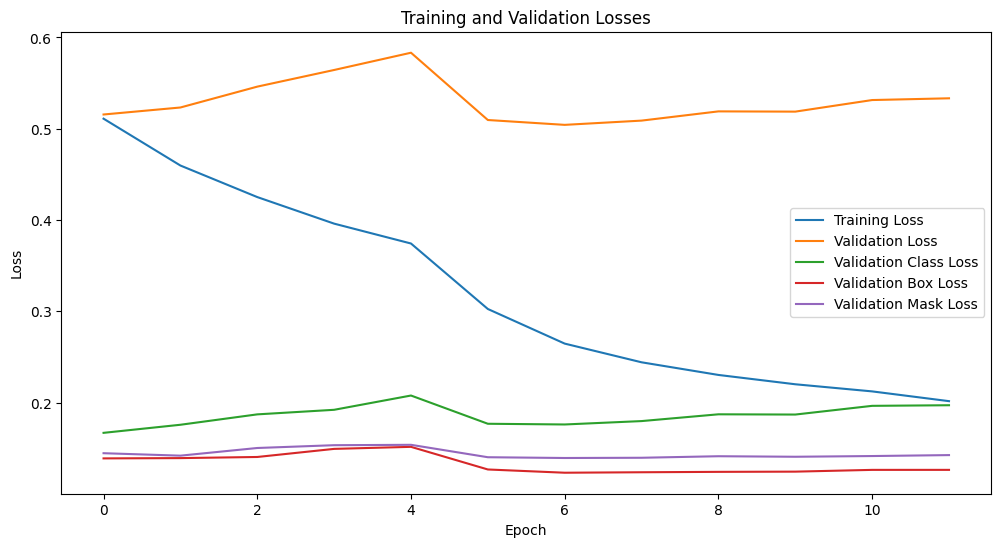

Loss history saved to loss_history.csv


In [13]:
import torch
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO 

# Assuming the FoodDataset and other necessary classes are defined as above

# Number of classes in your dataset
num_classes = 104  # Adjust this based on your dataset

# Model setup (e.g., maskrcnn_resnet50_fpn)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Replace the box predictor and mask predictor to match the number of classes
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features_box, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256  
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# To keep track of the best loss and save the best model
best_val_loss = float('inf')
train_losses, val_losses, class_losses, box_losses, mask_losses = [], [], [], [], []


def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    all_precisions = []
    all_recalls = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()

                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_labels = targets[i]['labels'].cpu().numpy()

                precision, recall = calculate_precision_recall(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold)
                
                all_precisions.append(precision)
                all_recalls.append(recall)

    mAP50 = calculate_map50(all_precisions)
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)

    return mAP50, avg_precision, avg_recall



# Load the checkpoint
start_epoch = 14  # Since we stopped at epoch 13
checkpoint_path = f"/kaggle/working/model_epoch_{start_epoch}.pth"

# Load the saved model
model.load_state_dict(torch.load("/kaggle/input/mask-r-cnn-output/model_epoch_13.pth"))
print(f"Resuming training from Epoch {start_epoch}")

# Optionally, load the optimizer and scheduler states if you saved them
# optimizer.load_state_dict(torch.load(optimizer_checkpoint_path))
# scheduler.load_state_dict(torch.load(scheduler_checkpoint_path))

# Resume the training loop from epoch 7
for epoch in range(start_epoch, 30):  # Continue from epoch 7
    model.train()
    running_loss = 0.0
    images_processed = 0

    # Training loop
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward pass (training)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        running_loss += losses.item()
        images_processed += len(images)

        # Print progress every 100 images
        if images_processed % 100 < len(images):
            print(f"Epoch [{epoch+1}], Processed {images_processed}/{len(train_loader.dataset)} images")


    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}], Training Loss: {avg_train_loss}")

    # Validation step
    model.eval()
    val_loss, val_class_loss, val_box_loss, val_mask_loss = 0.0, 0.0, 0.0, 0.0
    
    with torch.no_grad():
        model.train()  # Temporarily switch to training mode to compute loss
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Compute validation losses
            loss_dict = model(images, targets)

            classification_loss = loss_dict['loss_classifier']
            bbox_regression_loss = loss_dict['loss_box_reg']
            mask_loss = loss_dict.get('loss_mask', torch.tensor(0.0))

            total_loss = sum(loss for loss in loss_dict.values())
            val_loss += total_loss.item()
            val_class_loss += classification_loss.item()
            val_box_loss += bbox_regression_loss.item()
            val_mask_loss += mask_loss.item()

        model.eval()  # Switch back to evaluation mode after computing loss

    avg_val_loss = val_loss / len(val_loader)
    avg_val_class_loss = val_class_loss / len(val_loader)
    avg_val_box_loss = val_box_loss / len(val_loader)
    avg_val_mask_loss = val_mask_loss / len(val_loader)

    val_losses.append(avg_val_loss)
    class_losses.append(avg_val_class_loss)
    box_losses.append(avg_val_box_loss)
    mask_losses.append(avg_val_mask_loss)

    print(f"Epoch [{epoch+1}], Validation Loss: {avg_val_loss}")
    print(f"Epoch [{epoch+1}], Validation Class Loss: {avg_val_class_loss}")
    print(f"Epoch [{epoch+1}], Validation Box Loss: {avg_val_box_loss}")
    print(f"Epoch [{epoch+1}], Validation Mask Loss: {avg_val_mask_loss}")

    # Evaluate mAP@50, precision, and recall after each epoch on validation set
    mAP50, avg_precision, avg_recall = evaluate_model(model, val_loader, device)
    print(f"mAP@50: {mAP50}, Precision: {avg_precision}, Recall: {avg_recall}")
    
    # Save checkpoint after each epoch
    checkpoint_path = f"/kaggle/working/model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved checkpoint for Epoch {epoch+1} at {checkpoint_path}")


    # Early stopping (same as before)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print(f"Best model saved at Epoch {epoch+1} with Validation Loss: {best_val_loss}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:  # Assuming 5 epochs patience for early stopping
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss}")
            break

    # Step learning rate scheduler
    scheduler.step(avg_val_loss)

# After training is done, visualize the losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(class_losses, label='Validation Class Loss')
plt.plot(box_losses, label='Validation Box Loss')
plt.plot(mask_losses, label='Validation Mask Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Save the loss history to a CSV file
loss_data = pd.DataFrame({
    'epoch': range(1, len(train_losses)+1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'class_loss': class_losses,
    'box_loss': box_losses,
    'mask_loss': mask_losses
})
loss_data.to_csv('/kaggle/working/loss_history.csv', index=False)
print("Loss history saved to loss_history.csv")
